In [1]:
import torch.nn as nn
from torch.autograd import Variable
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as dset
from IPython.display import display, clear_output
from torch.autograd import Variable
import time

In [4]:
class convLSTMcell(nn.Module):
    def __init__(self, inputSize, inputDim, hiddenSize):
        super().__init__()
        self.inSize = inputSize
        self.hidSize = hiddenSize
        self.inDim = inputDim
        
        self.conv = conv4rnn(self.inSize + self.hidSize,
                            4 * self.hiddenSize)
        
    def forward(self, img, state):
        
        ht_1, ct_1 = state
        
        concat = torch.cat([img, ht_1], dim=1)
        
        conconv = self.conv(concat)
        cci, ccf, cco, ccg = torch.split(conconv, self.hidSize, dim=1)
        i = torch.sigmoid(cci)
        f = torch.sigmoid(ccf)
        o = torch.sigmoid(cco)
        g = torch.tanh(ccg)
        
        ct = f * ct_1 + i * g
        ht = o * torch.tanh(ct)
        
        return ht, ct
    
#--------------------------------------------------------------------
class convLSTM(nn.Module):
    def __init__(self, inputSize, inputDim, hiddenSize, numLayers):
        super().__init__()
        
        self.height, self.width = inputSize
        
        self.inSize = inputSize
        self.hidSize = hiddenSize
        self.inDim = inputDim
        self.lays = numLayers
        
        cells = []
        for i in range(0, self.lays):
            dim = self.inputDim if i==0 else self.hidSize[i-1]
            
            cells.append(convLSTMcell(inputSize=(self.height, self.width),
                                     inputDim=dim, hidSize=self.hidSize[i]))
        self.cells = nn.ModuleList(cells)
        
    #def forward(self, img, )

In [2]:
#-------------------------------------------------------------------
def conv4rnn(dimIn, dimOut):
    model = nn.Sequential(
        nn.Conv2d(dimIn, dimOut, kernel_size=3, stride=1,
                  padding=1),
        nn.BatchNorm2d(dimOut)
    )
    return model

#---------------------------------------------------------------------
def convRNN(inputIm, T, dimIn, dimOut):
    for t in range(T):
        if (t == 0):
            comb = torch.cat([inputIm, inputIm], dim=1)
        else:
            comb = torch.cat([inputIm, res], dim=1)
    
        self.conv = conv4rnn(dimIn*2, dimOut*2)
        comb_conv = self.conv(comb)
    
        cc_x, cc_h = torch.split(comb_conv, dimOut, dim=1)
    
        x = torch.sigmoid(cc_x)
        h = torch.sigmoid(cc_h)
    
        res = x + h
    
    return res
    
    
    #for t in range(T):
    #    i = torch.sigmoid(conv(dimIn, dimOut))

#---------------------------------------------------------------------


In [10]:
class DeLorean(nn.Module):
    def __init__(self, filtersNum, T):
        super().__init__()
        self.fil = filtersNum
        #self.hid = hiddenNum
        self.T = T
        
    def forward(self, image):
        
        res = convRNN(image, 4, 1, 16)
        
        return res

In [11]:
# parameters
batch_size = 10
img_size = 128
lr = 0.0005
epoch = 1
seq_len = 6

# Generator
net = DeLorean(3, 5)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
generator = nn.DataParallel(net)

img_dir = "./maps/"
trainset = dset.ImageFolder(root=img_dir,
                            transform = transforms.Compose([
                            transforms.Grayscale(num_output_channels=1),
                            transforms.Scale(size=img_size),
                            transforms.CenterCrop(size=(img_size,
                            img_size*2)),
                            transforms.ToTensor(),
                            ]))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=0)

recon_loss_func = nn.MSELoss()
gen_optimizer = torch.optim.Adam(net.parameters(),lr=lr)


ValueError: optimizer got an empty parameter list

In [5]:
t = time.time()
eta = ''
for ep in range(epoch):
    for i, (image, label) in enumerate(trainloader):
        
        # add sequence length
        image5 = np.tile(image, (seq_len,1,1,1,1))
        image5 = torch.FloatTensor(image5)
        
        ct, seg = torch.chunk(image5, chunks=2, dim=4)
        #print(satel_image.shape)
        
        gen_optimizer.zero_grad()
        
        if torch.cuda.is_available():
            x = Variable(ct).cuda(0) # add .cuda(0) for parallel
            y_ = Variable(seg).cuda(0)
        else:
            x = Variable(ct)
            y_ = Variable(seg)
        y = generator.forward(x)
        
        current_loss = recon_loss_func(y,y_)
        current_loss.backward()
        gen_optimizer.step()
        
        # status
        dt = time.time() - t
        t = time.time()
        eta = ETA(ep, epoch, i, batch_size, dt,
                      len(trainloader))
        status(batch_size, ep+1 , epoch, i, current_loss,
               trainloader, eta)   
        
        # images display
        if i%1 == 0:
            showAllImages(x,y,y_)
            time.sleep(2)

NameError: name 'trainloader' is not defined

torch.Size([10, 1, 128, 256])
torch.Size([6, 3, 1, 128, 256]) torch.Size([6, 3, 1, 128, 256]) torch.Size([6, 3, 1, 128, 256]) torch.Size([6, 1, 1, 128, 256])


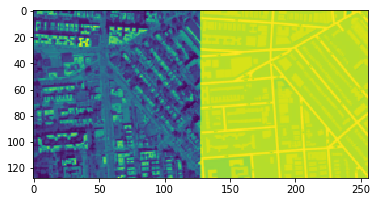

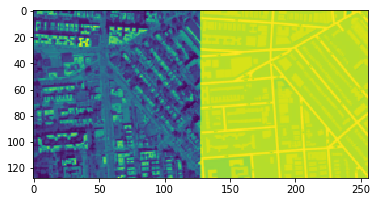

In [47]:
for ep in range(epoch):
    for i, (image, label) in enumerate(trainloader):
        
        print(image.shape)
        # add sequence length
        image5 = np.tile(image, [6,1,1,1,1])
        image5 = torch.FloatTensor(image5)
        
        a,b,c,d = torch.split(image5, 3, dim=1)
        print(a.shape, b.shape, c.shape, d.shape)
        
        
        im = image[1,:,:,:]
        plt.imshow(im.squeeze())
        plt.show()
        
        im = image5[1,1,:,:,:]
        plt.imshow(im.squeeze())
        plt.show()
        
        break